In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

/home/peta/petaLab/bayesian-iroha/.venv/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [4]:
print(f"PyMC version: {pm.__version__}")

# 再現性の確保
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

PyMC version: 5.26.1


In [102]:
# --- 1. Data の生成 (N=20 小規模Data) ---
def generate_weighted_scenario_data(n_per_page=20):
    """
    Top Page 改善、Checkout page 悪化の Trap-data 生成
    """
    pages = ["Top", "Detail", "Contract", "Checkout"]

    scenario = {
        'Top': (3000, 2500),  # 改善（良）
        'Detail': (2800, 2600),  # （微良）
        'Contract': (3500, 3550),  # 変化なし(微増)
        'Checkout': (3000, 4000)  #  悪化　★ここが罠
    }

    data = []
    for page in pages:
        mu_pre, mu_post = scenario[page]

        # Pre (対数正規分布)
        lcp_pre = rng.lognormal(mean=np.log(mu_pre), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "pre", "lcp": val} for val in lcp_pre])

        # Post (対数正規分布)
        lcp_post = rng.lognormal(mean=np.log(mu_post), sigma=0.4, size=n_per_page)
        data.extend([{"page": page, "group": "Post", "lcp": val} for val in lcp_post])

    return pd.DataFrame(data)

In [103]:
df = generate_weighted_scenario_data(n_per_page=20)

In [112]:
# 基本統計量の確認
print("--- 基本統計量（Group × Page） ---")

df.groupby("group").agg({"lcp": "mean"})

--- 基本統計量（Group × Page） ---


,lcp
group,
Post,3368.540709
pre,3367.991907


単純に `df.groupby("group").agg({"lcp": "mean"})` を見ると、Sample数が均等なため
- Pre: 3368ms -> Post: 3369ms

と、全体として大きな変化はありません。

In [106]:
df.groupby(["page", "group"]).agg({"lcp": "mean"}).unstack()  # 確認

# unstack() は、MultiIndex（重層的なインデックス）を持つ Series や DataFrame のインデックスの最下層を、カラム（列）へと展開（ピボット）する効果があります。
# このコードの場合、groupby(["page", "group"]) によってインデックスが page と group の二段構えになりますが、
# .unstack() を付けることで、group（pre/Post）が横に並び、ページごとの比較がしやすくなります。

lcp             
group            Post          pre
page                              
Checkout  4526.429897  3039.637570
Contract  3798.844753  3854.428841
Detail    2631.132025  3461.750649
Top       2517.756163  3116.150570

`Checkout` を見ると明確に悪化しています。

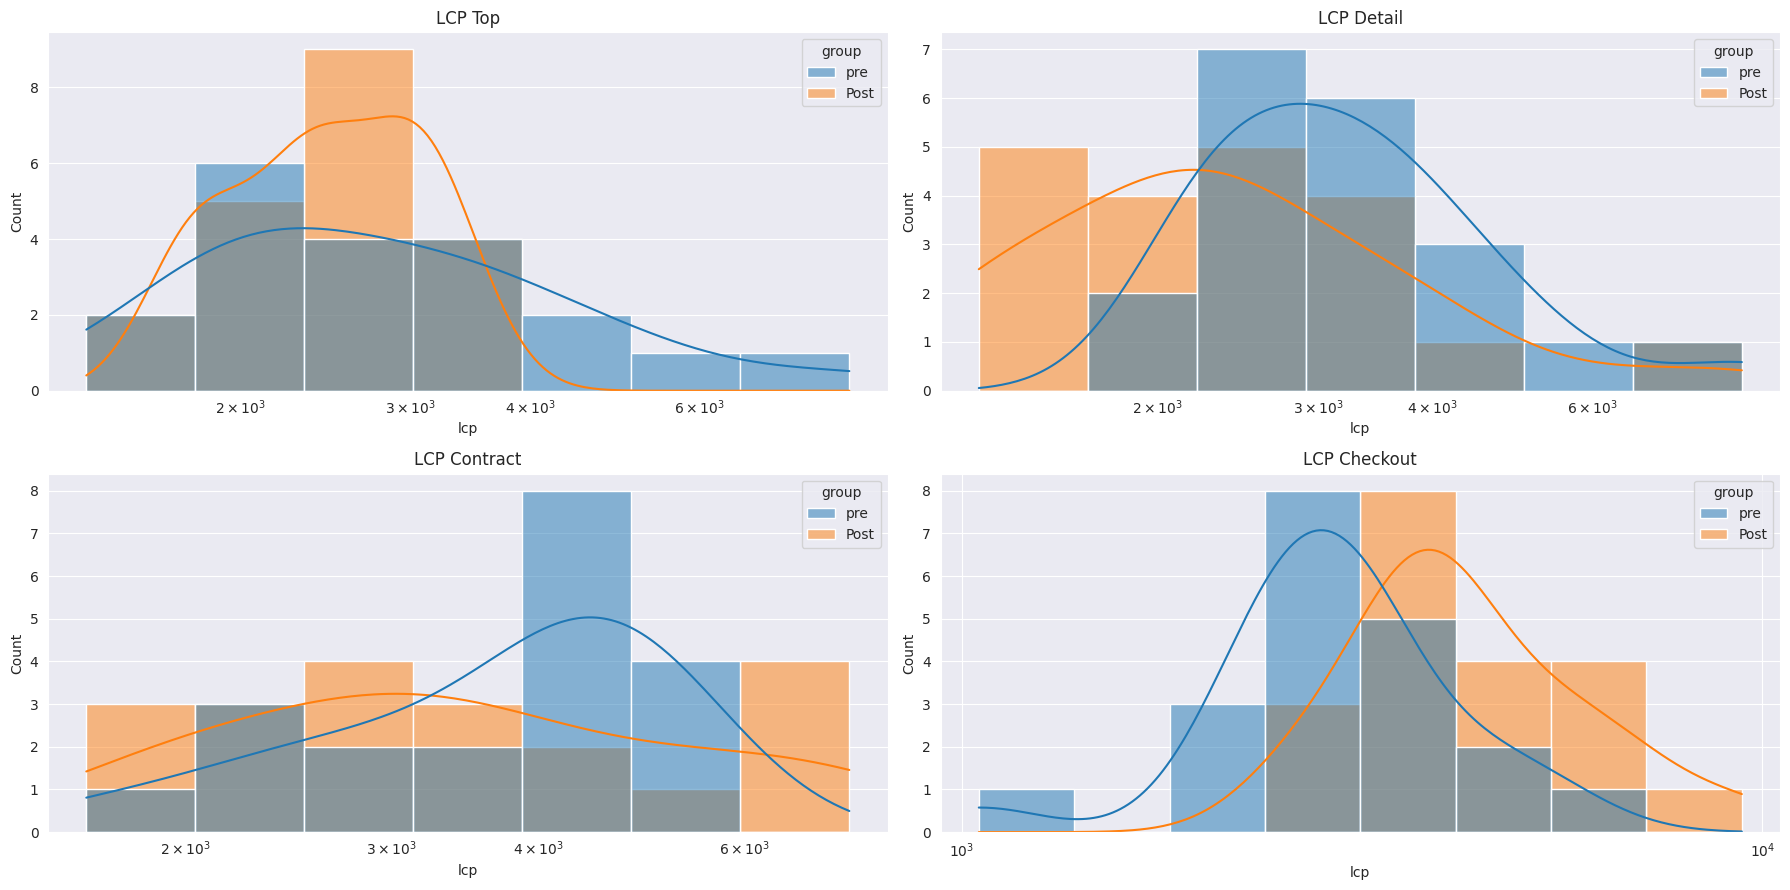

In [133]:
# 分布の可視化
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
ax_flat = axes.flatten()

for i, page in enumerate(df["page"].unique()):
    sns.histplot(data=df[df["page"] == page], x="lcp", hue="group", kde=True, log_scale=True, ax=ax_flat[i])
    ax_flat[i].set_title(f"LCP {page}")

plt.tight_layout()
plt.show()

この可視化において注目すべき点は、「平均値の罠」が視覚的に表現されていることです。

1. TopページとDetailページ（改善傾向）:
    青色（Pre）に比べて、オレンジ色（Post）の分布が左側（LCPが小さい、つまり高速な方向）にシフトしていることが見て取れます。特にTopページでは、ヒストグラムの山が明確に左へ移動しており、パフォーマンス改善の恩恵を最も受けていることがわかります。
2. Contractページ（変化なし）:
    PreとPostの分布がほぼ重なっており、施策による影響がほとんど見られません。
3. Checkoutページ（改悪傾向：重要）:
    ここが本分析の「罠」となる部分です。他のページとは逆に、オレンジ色（Post）の分布が右側（LCPが大きい、つまり低速な方向）へシフトし、裾野も広がっています。これは、決済画面において明確なパフォーマンス低下が発生していることを示唆しています。


> ##### 技術的補足と直感的な説明
>1. 対数正規分布と対数スケール (Log Scale)
【定義】: LCPのような待ち時間データは、下限が0で右側に長い裾を持つ性質があるため、通常は対数正規分布に従います。このプロットでは log_scale=True を使用することで、歪んだデータを正規分布に近い形に変換し、中心傾向（最頻値や中央値）のズレを視覚的に比較しやすくしています。
【直感】: 待ち時間のデータは、「すごく遅い人」が一部混じるため、単純な平均をとると実態を見誤ります。このグラフでは、データの「偏り」を調整して、PreとPostの「山の位置」がどれくらいズレたかを、人間の目で直感的に捉えやすい形に整えています。
2. カーネル密度推定 (KDE: Kernel Density Estimation)
【定義】: ヒストグラムに重なっている曲線はカーネル密度推定です。これは、離散的なデータポイントから連続的な確率密度関数を推定する手法であり、ヒストグラムのビン（棒）の切り方に依存せずに、データの分布形状を滑らかに表現します。
【直感】: 点々としたデータの集まりを、「なだらかな山」として描いたものです。山の形を見ることで、「だいたい何秒くらいのユーザーが一番多いのか」や「分布のばらつき（山の幅）」を一目で比較できるようになります。


#### 結論としての意思決定支援
このプロットから得られるビジネス上の洞察は、**「全ページ合計の平均値では改善しているように見えても、最も売上に直結する Checkout ページで致命的な遅延が発生している」**というリスクの可視化です。

In [111]:
# Category 変数の Index化）
idx_page, pages = pd.factorize(df["page"])
idx_group, groups = pd.factorize(df["group"])

# PyMC用 Coords (座標) 定義
coords = {
    "id_obs": df.index.values,
    "page": pages,
    "group": groups  # ["Pre", "Post"]"

}